# 1.模型创建步骤与nn.Module

Q:LeNet的组成结构是什么？
- ![](http://anki190912.xuexihaike.com/20201001184259.png)

Q:模型构建两要素是什么？
- 1.构建子模块：`__init__()`
- 2.拼接子模块：forward()

Q:torch.nn有哪4个模块及其功能？
- nn.Parameter：张量子类，表示可学习参数，如weight, bias
- nn.Module：所有网络层基类，管理网络属性
- nn.functional：函数具体实现，如卷积，池化，激活函数等
- nn.init：参数初始化方法

Q:nn.Module中有哪些属性？
- ```python
self._parameters = OrderedDict()
self._buffers = OrderedDict()
self._backward_hooks = OrderedDict()
self._forward_hooks = OrderedDict()
self._forward_pre_hooks = OrderedDict()
self._state_dict_hooks = OrderedDict()
self._load_state_dict_pre_hooks = OrderedDict()
self._modules = OrderedDict()
```
- parameters：存储管理nn.Parameter类，如权值、偏置
- modules：存储管理nn.Module类，如卷积层、池化层
- buffers：存储管理缓冲属性，如BN层中的running_mean
- ***_hooks：存储管理钩子函数


# 2.模型容器与AlexNet构建

Q:容器(Contianers)包含哪些组件以及作用？
- nn.Sequetial：按顺序包装多个网络层
- nn.ModuleList：像python的list一样包装多个网络层
- nn.ModuleDict：像python的dict一样包装多个网络层

Q:nn.Sequential是什么？
- nn.module的容器， 用于按顺序包装一组网络层
- 顺序性：各网络层之间严格按照顺序构建
- 自带forward()：自带的forward里， 通过for循环依次执行前向传播运算



In [1]:
import torch
import torchvision
import torch.nn as nn
from collections import OrderedDict

class LeNetSequential(nn.Module):
    def __init__(self, classes):
        super(LeNetSequential, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),)

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes),)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x


class LeNetSequentialOrderDict(nn.Module):
    def __init__(self, classes):
        super(LeNetSequentialOrderDict, self).__init__()

        self.features = nn.Sequential(OrderedDict({
            'conv1': nn.Conv2d(3, 6, 5),
            'relu1': nn.ReLU(inplace=True),
            'pool1': nn.MaxPool2d(kernel_size=2, stride=2),

            'conv2': nn.Conv2d(6, 16, 5),
            'relu2': nn.ReLU(inplace=True),
            'pool2': nn.MaxPool2d(kernel_size=2, stride=2),
        }))

        self.classifier = nn.Sequential(OrderedDict({
            'fc1': nn.Linear(16*5*5, 120),
            'relu3': nn.ReLU(),

            'fc2': nn.Linear(120, 84),
            'relu4': nn.ReLU(inplace=True),

            'fc3': nn.Linear(84, classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x


# net = LeNetSequential(classes=2)
net = LeNetSequentialOrderDict(classes=2)

fake_img = torch.randn((4, 3, 32, 32), dtype=torch.float32)

output = net(fake_img)

print(net)
print(output)

LeNetSequentialOrderDict(
  (features): Sequential(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU(inplace=True)
    (fc3): Linear(in_features=84, out_features=2, bias=True)
  )
)
tensor([[ 0.0957, -0.1115],
        [ 0.0936, -0.1168],
        [ 0.0842, -0.0981],
        [ 0.0986, -0.0969]], grad_fn=<AddmmBackward>)


In [ ]:
Q:nn.ModuleList是什么？
- nn.module的容器，用于包装一组网络层，以迭代方式调用网络层
- 主要方法：
    - append()：在ModuleList后面添加网络层
    - extend()：拼接两个ModuleList
    - insert()：指定在ModuleList中位置插入网络层
    


In [ ]:
Q:nn.ModuleDict是什么？
- nn.module的容器，用于包装一组网络层，以索引方式调用网络层
- 主要方法：
    - clear()：清空ModuleDict
    - items()：返回可迭代的键值对 (key - value pairs)
    - keys()：返回字典的键 (key)
    - values()：返回字典的值 (value)
    - pop()：返回一对键值，并从字典中删除

# 3.nn网络层-卷积层

Q:如何对多个二维信号进行二维卷积？
- `torch.nn.quantized.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`
- in_channels：输入通道数
- out_channels：输出通道数，等价于卷积核个数
- kernel_size：卷积核尺寸
- stride：步长
- padding：填充个数
- dilation：空洞卷积大小
- groups：分组卷积设置
- bias：偏置
- 尺寸计算：
- $$H_{\text {out}}=\left\lfloor\frac{H_{\text {in}}+2 \times \text { padding }[0]-\text { dilation }[0] \times(\text { kernel } \operatorname{size}[0]-1)-1}{\text { stride }[0]}+1\right]$$


卷积前尺寸:torch.Size([1, 3, 512, 512])
卷积后尺寸:torch.Size([1, 1, 510, 510])


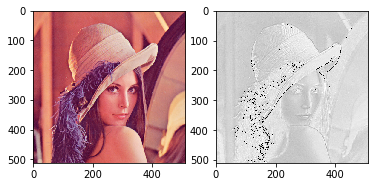

In [3]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from utils.common_tools import transform_invert, set_seed

set_seed(3)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("img", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ 2d

conv_layer = nn.Conv2d(3, 1, 3)   # input:(i, o, size) weights:(o, i , h, w)
nn.init.xavier_normal_(conv_layer.weight.data)

# calculation
img_conv = conv_layer(img_tensor)

# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

Q:转置卷积是什么？如何使用转置卷积实现上采样？
- 又称反卷积(Deconvolution)和部分跨越卷积(Fractionally-strided Convolution)，用于对图像进行上采样(UpSample)
- `torch.nn.ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[int, Tuple[int, int]] = 0, output_padding: Union[int, Tuple[int, int]] = 0, groups: int = 1, bias: bool = True, dilation: int = 1, padding_mode: str = 'zeros')`
- in_channels：输入通道数
- out_channels：输出通道数，等价于卷积核个数
- kernel_size：卷积核尺寸
- stride：步长
- padding：填充个数
- dilation：空洞卷积大小
- groups：分组卷积设置
- bias：偏置
- 尺寸计算：
- $$H_{\text {out}}=\left(H_{\text {in}}-1\right) \times \text { stride }[0]-2 \times \text { padding }[0]+\operatorname{dilation}[0] \times(\text { kernel } \operatorname{size}[0]-1)+\text { output_padding }[0]+1$$
- 生成的图像有棋盘效应，是由于不均匀重叠导致的
- 参考《Deconvolution and Checkboard Artifacts》

卷积前尺寸:torch.Size([1, 3, 512, 512])
卷积后尺寸:torch.Size([1, 1, 1025, 1025])


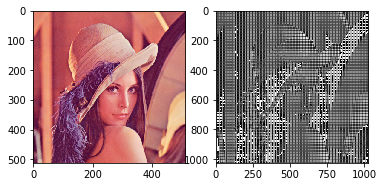

In [7]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from utils.common_tools import transform_invert, set_seed

set_seed(2)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("img", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ transposed
conv_layer = nn.ConvTranspose2d(3, 1, 3, stride=2)   # input:(i, o, size)
nn.init.xavier_normal_(conv_layer.weight.data)

# calculation
img_conv = conv_layer(img_tensor)


# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

# 4.nn网络层-池化-线性-激活函数层

Q:如何对二维信号（图像）进行最大值池化?
- `torch.nn.MaxPool2d(kernel_size: Union[int, Tuple[int, ...]], stride: Union[int, Tuple[int, ...], None] = None, padding: Union[int, Tuple[int, ...]] = 0, dilation: Union[int, Tuple[int, ...]] = 1, return_indices: bool = False, ceil_mode: bool = False)`
- kernel_size：池化核尺寸
- stride：步长
- padding：填充个数
- dilation：池化核间隔大小
- ceil_mode：尺寸向上取整
- return_indices：记录池化像素索引，用于反池化

Q:最大池化代码示例？

池化前尺寸:torch.Size([1, 3, 512, 512])
池化后尺寸:torch.Size([1, 3, 256, 256])


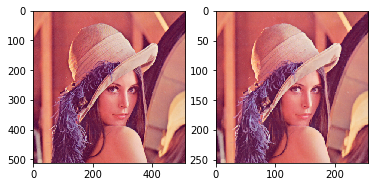

In [9]:
import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from utils.common_tools import transform_invert, set_seed

set_seed(1)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("img", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ maxpool

maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2))   # input:(i, o, size) weights:(o, i , h, w)
img_pool = maxpool_layer(img_tensor)

# ================================= visualization ==================================
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


Q:如何对二维信号（图像）进行平均值池化？
- `torch.nn.AvgPool2d(kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int], None] = None, padding: Union[int, Tuple[int, int]] = 0, ceil_mode: bool = False, count_include_pad: bool = True, divisor_override: bool = None)`
- kernel_size：池化核尺寸
- stride：步长
- padding：填充个数
- ceil_mode：尺寸向上取整
- count_include_pad：填充值用于计算
- divisor_override：除法因子，默认是池化核个数

Q:平均池化的代码示例

池化前尺寸:torch.Size([1, 3, 512, 512])
池化后尺寸:torch.Size([1, 3, 256, 256])


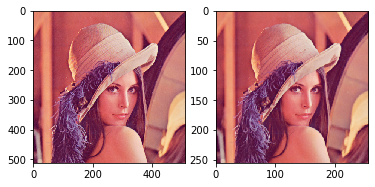

In [10]:
import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from utils.common_tools import transform_invert, set_seed

set_seed(1)  # 设置随机种子

# ================================= load img ==================================
path_img = os.path.join("img", "lena.png")
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ avgpool
avgpoollayer = nn.AvgPool2d((2, 2), stride=(2, 2))   # input:(i, o, size) weights:(o, i , h, w)
img_pool = avgpoollayer(img_tensor)

# ================================= visualization ==================================
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


Q:如何对二维信号（图像）进行最大值池化上采样?
- `torch.nn.MaxUnpool2d(kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int], None] = None, padding: Union[int, Tuple[int, int]] = 0)`
- kernel_size：池化核尺寸
- stride：步长
- padding：填充个数
- ![](http://anki190912.xuexihaike.com/20201003121757.png)

Q:最大池化上采样代码示例？

In [12]:
import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
from torchvision import transforms
from utils.common_tools import transform_invert, set_seed

set_seed(1)  # 设置随机种子

# pooling
img_tensor = torch.randint(high=5, size=(1, 1, 4, 4), dtype=torch.float)
maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)
img_pool, indices = maxpool_layer(img_tensor)

# unpooling
img_reconstruct = torch.randn_like(img_pool, dtype=torch.float)
maxunpool_layer = nn.MaxUnpool2d((2, 2), stride=(2, 2))
img_unpool = maxunpool_layer(img_reconstruct, indices)

print("raw_img:\n{}\nimg_pool:\n{}".format(img_tensor, img_pool))
print("img_reconstruct:\n{}\nimg_unpool:\n{}".format(img_reconstruct, img_unpool))

raw_img:
tensor([[[[0., 4., 4., 3.],
          [3., 3., 1., 1.],
          [4., 2., 3., 4.],
          [1., 3., 3., 0.]]]])
img_pool:
tensor([[[[4., 4.],
          [4., 4.]]]])
img_reconstruct:
tensor([[[[-1.0276, -0.5631],
          [-0.8923, -0.0583]]]])
img_unpool:
tensor([[[[ 0.0000, -1.0276, -0.5631,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [-0.8923,  0.0000,  0.0000, -0.0583],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]])
